In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import scipy
import statsmodels.stats.multitest as multiple

data_folder = './MovieSummaries/'

plot = pd.read_csv(data_folder+'plot_summaries.txt', sep='	', header=None, names=["wiki_id", "summary"])
movie_meta = pd.read_csv(data_folder+'movie.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "movie_name", "release_date", "revenue", "runtime", "languages", "coutries", "genres"])
char_meta = pd.read_csv(data_folder+'character.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "release_date", "character_name", "birth", "gender", "height", "ethnicity", "actor_name", "actor_age", "character_actor_map", "character_id", "actor_id"])
#tvtropes_clusters = pd.read_csv(data_folder+'tvtropes.clusters.txt')
#name_clusters = pd.read_csv(data_folder+'name.clusters.txt')
df = plot.merge(movie_meta, on="wiki_id", how='right')
df["languages"] = df.apply(lambda x: list(eval(x["languages"]).values()), axis=1)
df["coutries"] = df.apply(lambda x: list(eval(x["coutries"]).values()), axis=1)
df["genres"] = df.apply(lambda x: list(eval(x["genres"]).values()), axis=1)

In [2]:
import datetime

df.summary = df.summary.fillna('')
df.loc[df['wiki_id']== 29666067, 'release_date'] = datetime.datetime(2010, 12, 2)
dates = pd.to_datetime(df['release_date'])
df['release_date'] = dates

In [3]:
def plot_proportion(proportion,title):
    proportion.plot.bar(rot=45, figsize=(10, 6))
    plt.locator_params(nbins=20)
    plt.title(title)
    return proportion

In [4]:
def create_proportion_by_year(number_of_films):
    tot_by_year = df.groupby(df.release_date.dt.year)['wiki_id'].count()
    number_of_films_by_year = number_of_films.groupby(number_of_films.release_date.dt.year)['wiki_id'].count()
    number_of_films_by_year = number_of_films_by_year/tot_by_year
    return number_of_films_by_year.apply(lambda x: 0 if np.isnan(x) else x)

In [5]:
def proportion_of_movies_with_war_in_summary(df, title):
    pd.options.mode.chained_assignment = None
    war_movies = df[df.summary.str.lower().str.contains('war')]
    proportion_summary = create_proportion_by_year(war_movies)
    return plot_proportion(proportion_summary, title)

In [6]:
def proportion_of_nazis_in_summary(df, title):
    pd.options.mode.chained_assignment = None
    movies_with_nazis = df[df.summary.str.lower().str.contains('nazi')]
    nazis_by_year = create_proportion_by_year(movies_with_nazis)
    return plot_proportion(nazis_by_year, title)

In [7]:
def proportion_of_war_movies(df, title):
    war_movies_genre = df[df.genres.apply(lambda x :'War film' in x)]
    proportion_genre = create_proportion_by_year(war_movies_genre)
    return plot_proportion(proportion_genre, title)

In [8]:
def proportion_of_anti_war_movies(df, title):
    anti_war_movies_genre = df[df.genres.apply(lambda x :'Anti-war' in x)]
    proportion_anti_genre = create_proportion_by_year(anti_war_movies_genre)
    return plot_proportion(proportion_anti_genre, title)

In [9]:
def p_value_for_diff_years(war_movies, ind, WWII_ind):
    WWII=war_movies.loc[(war_movies.index <= WWII_ind[1]) & (war_movies.index >= WWII_ind[0])]
    p_values = []
    for lower, upper in ind:
        other = war_movies.loc[(war_movies.index <= upper) & (war_movies.index >= lower)]
        stat, p_value = scipy.stats.ttest_ind(WWII, other)
        p_values.append(p_value)
    return p_values

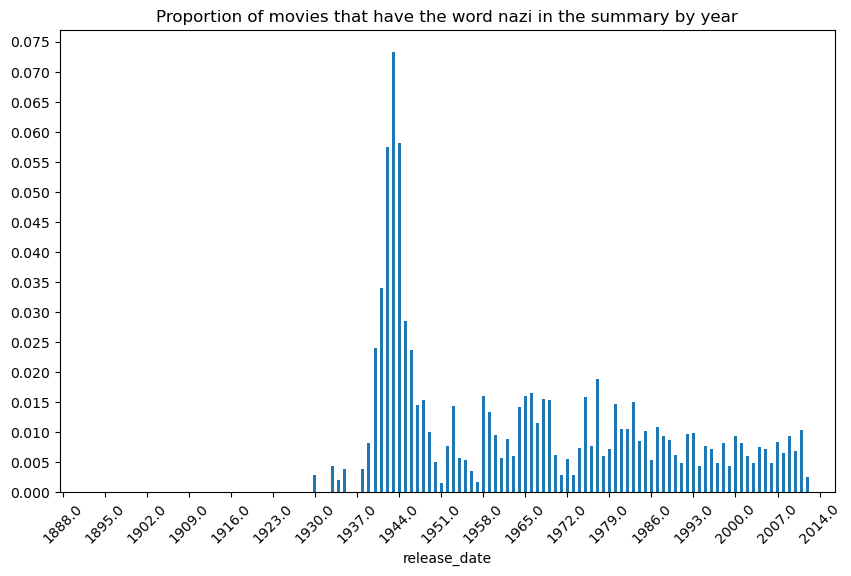

In [10]:
nazis_in_summaries=proportion_of_nazis_in_summary(df, "Proportion of movies that have the word nazi in the summary by year")

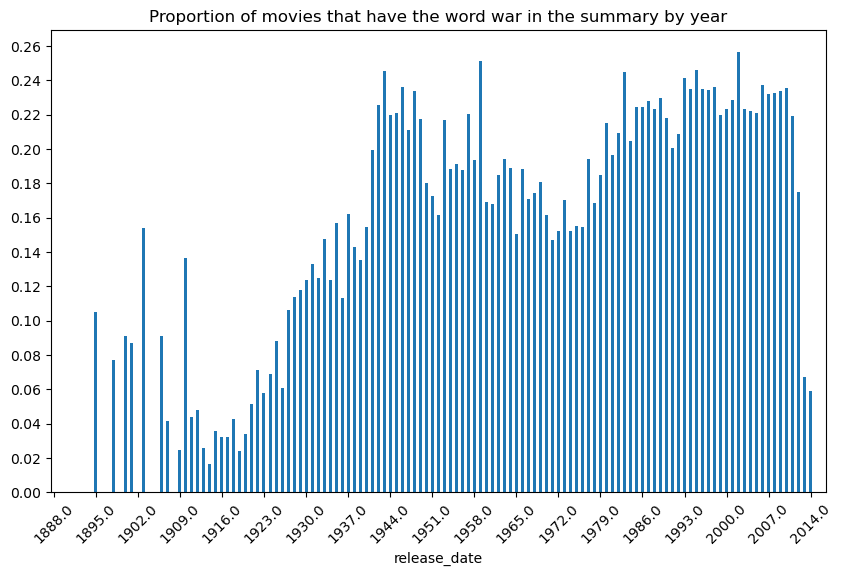

In [11]:
war_movies_by_year_summary=proportion_of_movies_with_war_in_summary(df, "Proportion of movies that have the word war in the summary by year")

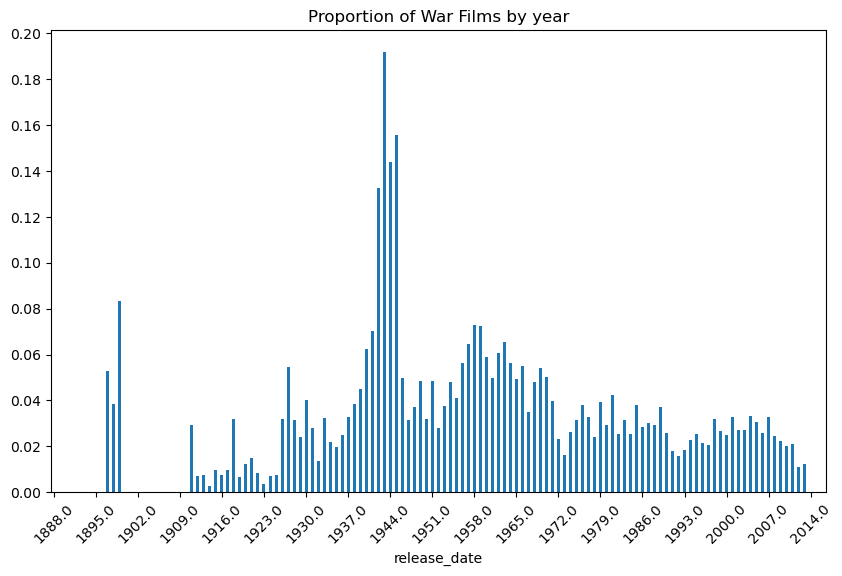

In [12]:
war_movies_by_year = proportion_of_war_movies(df, "Proportion of War Films by year")

In [13]:
WWII_ind = (1939,1945)

In [14]:
a =np.arange(1918, 2000, 7)
b = np.arange(1924, 2007, 7)
indexes = list(zip(a,b))
p_values_genres = p_value_for_diff_years(war_movies_by_year, indexes, WWII_ind)
p_values_summaries = p_value_for_diff_years(war_movies_by_year_summary, indexes, WWII_ind)
p_values_nazis = p_value_for_diff_years(nazis_in_summaries, indexes, WWII_ind)

In [15]:
multi_genres = multiple.multipletests(p_values_genres)
multi_summaries = multiple.multipletests(p_values_summaries)
multi_nazis = multiple.multipletests(p_values_nazis)

C:\Users\basti\anaconda3\envs\ada\lib\site-packages\statsmodels\stats\multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [16]:
multi_summaries

(array([ True,  True,  True, False, False, False, False, False, False,
        False, False, False]),
 array([1.29408293e-05, 2.20886646e-03, 3.21182142e-02, 1.00000000e+00,
        9.94926623e-01, 9.74815149e-01, 7.46913311e-01, 3.61129771e-01,
        7.46913311e-01, 7.46913311e-01, 7.46913311e-01, 4.13588830e-01]),
 0.004265318777560645,
 0.004166666666666667)

In [17]:
multi_genres

(array([ True,  True,  True, False,  True, False, False,  True,  True,
         True,  True,  True]),
 array([0.00498761, 0.01565773, 0.01213519, 1.        , 0.02008493,
        0.05086072, 0.05086072, 0.02008493, 0.01565773, 0.01565773,
        0.01152255, 0.01213519]),
 0.004265318777560645,
 0.004166666666666667)

In [18]:
multi_nazis

(array([ True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True]),
 array([0.00651498, 0.00653679, 0.00836356, 1.        , 0.02641913,
        0.02641913, 0.02641913, 0.02641913, 0.02641913, 0.02641913,
        0.02114796, 0.02114796]),
 0.004265318777560645,
 0.004166666666666667)

We can see that for a surface search on the summaries we can't find a statistically significant difference between the movies made during the world war two and after. But we can find a statistical difference between movies made during World War II as there are significantly more War Movies made during World War II (it isn't statistically significant if we take a threshold at 0.05, but if we take a threshold slightly higher like 0.06, then it is statistically significant. So we can say that it is mostly significant). Also the word Nazi is used significantly more in plots during the world war, which makes sense considering the context, although we might need to look if the movies are made in the US or in Germany, this might have a different meaning.

In [19]:
usDf = df[df.coutries.apply(lambda x :'United States of America' in x)]

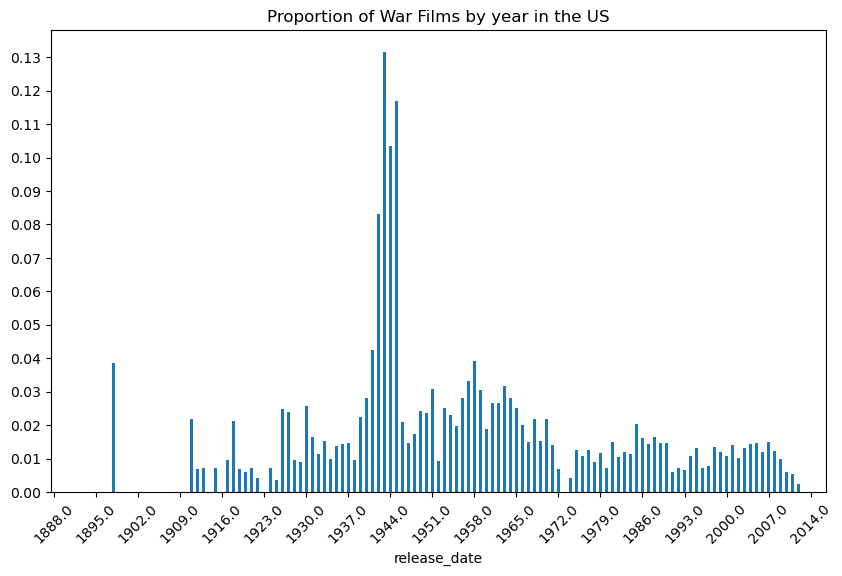

In [20]:
prop_war_films = proportion_of_war_movies(usDf, "Proportion of War Films by year in the US")

In [21]:
german_Nazi_movies = proportion_of_nazis_in_summary(germanyDf, "Proportion of German movies that have the word nazi in their plots by year")

NameError: name 'germanyDf' is not defined

In [ ]:
american_Nazi_movies = proportion_of_nazis_in_summary(usDf, "Proportion of American movies that have the word nazi in their plots by year")

In [ ]:
multiple.multipletests(p_value_for_diff_years(american_Nazi_movies, indexes, WWII_ind), alpha=0.06)

In [ ]:
multiple.multipletests(p_value_for_diff_years(german_Nazi_movies, indexes, WWII_ind), alpha=0.06)

We can see that the difference of plots that use the word Nazi in American movies during world war II is significant, but not for movies made in Germany. This doesn't make sense considering the context of the time, but might make sens considering the bias of the data that mostly contains american movies. Although we might notice also that German movies contain in proportion way more movies with Nazis in them and that they appear in 1930 whereas in American movies they first appear in 1939. We should increase the size of German movies during and after World War II in the dataset to continue this analysis.

In [ ]:
germanyDf = df[df.coutries.apply(lambda x :'Germany' in x)]
number_of_German_movies =plot_proportion(germanyDf.groupby(germanyDf.release_date.dt.year)['wiki_id'].count(), 'Number of German movies by year')